# **ВТОРАЯ ЧАСТЬ  - МОДЕЛИРОВАНИЕ'**

---

*   2) Data modelling Предсказание совершение целевого действия(ориентировочное значение ROC-AUC ~ 0.65) — факт совершения пользователей целевого действия.Разработать модель предсказания совершения одного из целевых действий ("Заказать звонок", "Оставить заявку") для сессий по введенным атрибутам типа utm_, device_, geo_* и упаковать модель в сервис.


*   3) Deployment Упаковка получившейся модели в сервис, который будет брать на вход все атрибуты, типа utm_*, device_*, geo_*, и отдавать на выход 0/1 (1 — если пользователь совершит любое целевое действие)

*   4) Подговка получившихся артефактов, проверка их на соответствие итоговым критериям оценки 




Целевая метрика: ориентировочное значение roc-auc > 0.65 — факт совершения пользователем целевого действия.

Формат вывода ответа - 0/1

Скорость ответа сервиса - не более 3 секунд

Сервис - это должен быть (минимум) - py-скрипт с инструкцией по запуску, (максимум) - localhost web app.




# **ИМПОРТ БИБЛИОТЕК**

---

In [1]:
!pip install xgboost 
!pip install lightgbm 
!pip install bayesian-optimization
!pip install feature-engine
!pip install bayesian-optimization
!pip install colorama



import scipy
import sys
from datetime import datetime
import warnings
from pathlib import Path
from typing import Union
from functools import partial
import time
import os
import warnings
warnings.filterwarnings('ignore')

# препроцессинг и метрики

from matplotlib import pyplot
import seaborn as sns
import pandas as pd
import numpy as np
import scipy.stats as stats
from sklearn.preprocessing import FunctionTransformer, StandardScaler
from sklearn.model_selection import (
    train_test_split, GridSearchCV, StratifiedKFold)
from sklearn.metrics import (
    roc_auc_score, accuracy_score, confusion_matrix, precision_score, 
    recall_score, f1_score, make_scorer, roc_curve)
from sklearn.pipeline import Pipeline
from feature_engine.encoding import RareLabelEncoder, OneHotEncoder
from feature_engine.wrappers import SklearnTransformerWrapper
from feature_engine.outliers import Winsorizer
from feature_engine.selection import (
    DropDuplicateFeatures, DropConstantFeatures, 
    DropCorrelatedFeatures, DropFeatures)
from feature_engine.transformation import YeoJohnsonTransformer
from bayes_opt import BayesianOptimization

# модели
from sklearn.base import BaseEstimator
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import (
    RandomForestClassifier, HistGradientBoostingClassifier)
from catboost import CatBoostClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

# Загрузка датасет sessions.csv с колонкой target

In [2]:
path = os.path.expanduser('~/PycharmProjects/FinalFantasyProj/')
start = time.time() # включим таймер для подсчета времени чтения файла в датасет
df_session = pd.read_csv(path + 'df_sessions_prepared_for_modelling.csv', low_memory=False)
elapsed_time = time.time() - start # зафиксируем время чтения файлма в датасет
print(f'Датасет сеансов успешно прочитан из файла ga_sessions.csv, \nРазмеры датасета: {df_session.shape}, \nВремя чтения файла в датасет: {elapsed_time:.3f}')

Датасет сеансов успешно прочитан из файла ga_sessions.csv, 
Размеры датасета: (1226382, 29), 
Время чтения файла в датасет: 2.898


# ПОДГОТОВКА К МОДЕЛИРОВАНИЮ

---
Существуют различные способы повышения качества работы моделей машинного обучения. Одним из таких способов является создание новых признаков. в блокноте 1 части создались такие новые признаки как 
car_brand
car_model
visit_date_day
visit_time_hour
visit_time_night
visit_number_no_outliers
device_screen_width
device_screen_height
device_screen_area
device_screen_ratio




In [3]:
target = df_session[['session_id', 'target']]
target

,session_id,target
0,9055446045651783499.1640648526.1640648526,0
1,9055447046360770272.1622255345.1622255345,0
2,9055447192389856083.1622453074.1622453074,0
3,9055455318486370642.1640843788.1640843788,0
4,9055461992850812764.1626107740.1626107740,0
...,...,...
1226377,9055422955903931195.1636979515.1636979515,0
1226378,9055422955903931195.1636979515.1636979515,0
1226379,9055422955903931195.1636979515.1636979515,0
1226380,9055430416266113553.1640968742.1640968742,0


In [4]:
df_session.describe(include='all')
#удалим категориальные колонки, которые не будем преобразовывать в OHE
df_session = df_session.drop(['session_id', 'visit_number', 'utm_source', 'utm_medium', 'utm_campaign',
                             'utm_adcontent', 'device_brand', 'device_screen_resolution', 
                             'geo_country', 'geo_city', 'car_model'], axis=1)
print(df_session.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1226382 entries, 0 to 1226381
Data columns (total 18 columns):
 #   Column                                  Non-Null Count    Dtype  
---  ------                                  --------------    -----  
 0   device_category                         1226382 non-null  object 
 1   device_browser                          1226382 non-null  object 
 2   target                                  1226382 non-null  int64  
 3   car_brand                               1226382 non-null  object 
 4   visit_date_weekday                      1226382 non-null  int64  
 5   visit_date_month                        1226382 non-null  int64  
 6   visit_date_weekend                      1226382 non-null  bool   
 7   visit_date_day                          1226382 non-null  int64  
 8   visit_time_hour                         1226382 non-null  int64  
 9   visit_time_night                        1226382 non-null  bool   
 10  device_screen_width           

In [5]:
pd.options.display.float_format = '{:.5f}'.format
df_session.describe()

,target,visit_date_weekday,visit_date_month,visit_date_day,visit_time_hour,device_screen_width,device_screen_height,device_screen_area,device_screen_ratio,geo_city_distance_from_moscow
count,1226382.00000,1226382.00000,1226382.00000,1226382.00000,1226382.00000,1226382.00000,1226382.00000,1226382.00000,1226382.00000,1226382.00000
mean,0.04354,2.79933,9.68030,17.18616,13.74962,707.70650,862.08432,671335.10192,0.77833,528.46869
std,0.20407,1.98127,2.15346,8.68806,6.12205,594.65453,154.62452,730411.86057,0.53899,970.96074
min,0.00000,0.00000,5.00000,1.00000,0.00000,180.00000,256.00000,57600.00000,0.32956,-1.00000
25%,0.00000,1.00000,8.00000,10.00000,10.00000,375.00000,780.00000,288000.00000,0.46182,0.00000
50%,0.00000,3.00000,10.00000,18.00000,14.00000,412.00000,851.00000,343089.00000,0.46220,19.15257
75%,0.00000,4.00000,11.00000,25.00000,19.00000,640.00000,900.00000,456036.00000,0.62529,636.16951
max,1.00000,6.00000,12.00000,31.00000,23.00000,5760.00000,5120.00000,20971520.00000,5.33333,6798.01868


In [6]:
#Сделаем преобразования в колонке device_browser для дальнейшего OHE моделирования
df_session['device_browser'].value_counts()
df_session.loc[df_session['device_browser'] == '(not set)', 'device_browser'] = df_session['device_browser'].apply(lambda x: 'Chrome')
df_session.loc[df_session['device_browser'] == 'Instagram 208.0.0.32.135 Android', 'device_browser'] = df_session['device_browser'].apply(lambda x: 'Instagram')
df_session.loc[df_session['device_browser'] == 'Instagram 209.0.0.21.119 Android', 'device_browser'] = df_session['device_browser'].apply(lambda x: 'Instagram')
df_session.loc[df_session['device_browser'] == 'Instagram 207.0.0.28.118', 'device_browser'] = df_session['device_browser'].apply(lambda x: 'Instagram')
df_session.loc[df_session['device_browser'] == 'Instagram 216.0.0.12.135', 'device_browser'] = df_session['device_browser'].apply(lambda x: 'Instagram')
df_session.loc[df_session['device_browser'] == 'Instagram 216.1.0.21.137 Android', 'device_browser'] = df_session['device_browser'].apply(lambda x: 'Instagram')
df_session.loc[df_session['device_browser'] == 'Instagram 208.0.0.26.131', 'device_browser'] = df_session['device_browser'].apply(lambda x: 'Instagram')
df_session.loc[df_session['device_browser'] == 'Mozilla Compatible Agent', 'device_browser'] = df_session['device_browser'].apply(lambda x: 'Mozilla')
df_session.loc[df_session['device_browser'] == 'Coc Coc', 'device_browser'] = df_session['device_browser'].apply(lambda x: 'other')
df_session.loc[df_session['device_browser'] == 'Konqueror', 'device_browser'] = df_session['device_browser'].apply(lambda x: 'other')
df_session.loc[df_session['device_browser'] == 'Nokia501', 'device_browser'] = df_session['device_browser'].apply(lambda x: 'other')
df_session.loc[df_session['device_browser'] == 'NokiaX2-02', 'device_browser'] = df_session['device_browser'].apply(lambda x: 'other')
df_session.loc[df_session['device_browser'] == 'MyApp', 'device_browser'] = df_session['device_browser'].apply(lambda x: 'other')
df_session.loc[df_session['device_browser'] == 'SeaMonkey', 'device_browser'] = df_session['device_browser'].apply(lambda x: 'other')
df_session.loc[df_session['device_browser'] == 'Android Browser', 'device_browser'] = df_session['device_browser'].apply(lambda x: 'Android Webview')
df_session.loc[df_session['device_browser'] == 'Opera Mini', 'device_browser'] = df_session['device_browser'].apply(lambda x: 'Opera')
df_session.loc[df_session['device_browser'] == '[FBAN', 'device_browser'] = df_session['device_browser'].apply(lambda x: 'FBAN')
df_session.loc[df_session['device_browser'] == 'Amazon Silk', 'device_browser'] = df_session['device_browser'].apply(lambda x: 'other')
df_session.loc[df_session['device_browser'] == 'Maxthon', 'device_browser'] = df_session['device_browser'].apply(lambda x: 'other')
df_session.loc[df_session['device_browser'] == 'helloworld', 'device_browser'] = df_session['device_browser'].apply(lambda x: 'other')
df_session.loc[df_session['device_browser'] == 'MRCHROME', 'device_browser'] = df_session['device_browser'].apply(lambda x: 'Chrome')
df_session.loc[df_session['device_browser'] == 'Android Runtime', 'device_browser'] = df_session['device_browser'].apply(lambda x: 'Android Webview')

In [7]:
df_session['device_browser'].value_counts()

Chrome               612818
Safari               355027
YaBrowser             97515
Safari (in-app)       59738
Android Webview       37767
Samsung Internet      17960
Opera                 15252
Firefox               14998
Edge                  14591
UC Browser              361
Instagram               135
FBAN                    109
Mozilla                  54
other                    27
Puffin                   17
Internet Explorer        13
Name: device_browser, dtype: int64

## Square, sqrt & log of numerical columns

In [8]:
def sqr_sqrt_log_features_transform(df_session: pd.DataFrame,
                                    sqr_miss: list=None,
                                    sqrt_miss: list=None,
                                    log_miss: list=None,
                                   ) -> pd.DataFrame:
    """
    Function transforms dataset adding squares, square roots and logarithm of numerical features
    
    :param df:  input data frame
    :sqr_miss:  columns, that should be missed for square feature generation
    :sqrt_miss: columns, that should be missed for square root feature generation
    :log_miss:  columns, that should be missed for logarithm feature generation
    
    :return:    dataframe with added features
    """
    
    df = df_session.copy()
    numeric_cols = df.select_dtypes(include=[np.number]).columns
    for col in numeric_cols:
        if ~np.isin(col, sqrt_miss):
            df[f'{col}_sqr'] = np.square(df[col])
        if ~np.isin(col, sqrt_miss):
            df[f'{col}_sqrt'] = np.sqrt(df[col])
        if ~np.isin(col, log_miss):
            df[f'{col}_log'] = np.log(df[col] + 0.01)    
    return df

In [9]:
df_session = sqr_sqrt_log_features_transform(df_session, 
                                       sqr_miss=['target'],
                                       sqrt_miss=['target'],
                                       log_miss=['target'],
                                     )
df_session.shape

(1226382, 45)

# FEATURE GENERATION

In [10]:
for_ohe=df_session[['device_category', 'car_brand', 'visit_time_night', 
                    'geo_country_is_russia', 'geo_city_is_big', 'visit_date_weekend',
                    'geo_city_distance_from_moscow_category', 'device_browser']]

In [11]:
from sklearn.preprocessing import OneHotEncoder
ohe = OneHotEncoder(sparse=False)
ohe.fit(for_ohe)
ohe.get_feature_names()
ohe_categor = ohe.transform(for_ohe)
df_session[ohe.get_feature_names()] = ohe_categor
df_session.shape

(1226382, 97)

In [12]:
#удалим категориальные колонки
df_session = df_session.drop(['device_category', 'car_brand', 'visit_time_night', 
                    'geo_country_is_russia', 'geo_city_is_big', 'visit_date_weekend',
                    'geo_city_distance_from_moscow_category', 'device_browser'], axis=1)
df_session.shape

(1226382, 89)

In [13]:
# проверим на дубликаты, удалим их
df_session[df_session.duplicated()].shape

(331435, 89)

In [14]:
df_session = df_session.drop_duplicates()
df_session[df_session.duplicated()].shape

(0, 89)

In [15]:
df_session=df_session.dropna(how='all') 

In [16]:
df_session.shape

(894947, 89)

# train-test split
Оценим базовую модель.
Так как целевая переменная распределена не равномерно, то в качестве бейзлайна можно выбрать стратегию, которая для каждой сессии предсказывает значение 0.

In [17]:
train_no_target=df_session.drop(['target'], axis=1)
X=train_no_target
y=df_session['target']
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=40, stratify=y)

# Нормализация данных

In [18]:
pd.options.display.float_format = '{:.5f}'.format
df_session.describe()

,target,visit_date_weekday,visit_date_month,visit_date_day,visit_time_hour,device_screen_width,device_screen_height,device_screen_area,device_screen_ratio,geo_city_distance_from_moscow,...,x7_Internet Explorer,x7_Mozilla,x7_Opera,x7_Puffin,x7_Safari,x7_Safari (in-app),x7_Samsung Internet,x7_UC Browser,x7_YaBrowser,x7_other
count,894947.00000,894947.00000,894947.00000,894947.00000,894947.00000,894947.00000,894947.00000,894947.00000,894947.00000,894947.00000,...,894947.00000,894947.00000,894947.00000,894947.00000,894947.00000,894947.00000,894947.00000,894947.00000,894947.00000,894947.00000
mean,0.05355,2.86492,9.77434,16.95957,13.56614,696.55445,854.96279,653977.85053,0.77448,635.11088,...,0.00001,0.00006,0.01537,0.00002,0.24230,0.04609,0.01817,0.00036,0.09153,0.00003
std,0.22512,1.98223,2.08595,8.70401,6.22046,585.87235,151.54763,717375.49081,0.53614,1058.83215,...,0.00351,0.00755,0.12303,0.00423,0.42848,0.20967,0.13355,0.01896,0.28837,0.00529
min,0.00000,0.00000,5.00000,1.00000,0.00000,180.00000,256.00000,57600.00000,0.32956,-1.00000,...,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
25%,0.00000,1.00000,9.00000,10.00000,9.00000,375.00000,771.00000,288000.00000,0.46181,0.00000,...,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
50%,0.00000,3.00000,10.00000,17.00000,14.00000,393.00000,851.00000,343089.00000,0.46659,179.35416,...,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
75%,0.00000,5.00000,11.00000,24.00000,19.00000,534.00000,900.00000,407968.00000,0.62474,727.52438,...,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
max,1.00000,6.00000,12.00000,31.00000,23.00000,5760.00000,5120.00000,20971520.00000,5.33333,6798.01868,...,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000


In [19]:
# еще одна нормализация - это min-max нормализация значения [0;1]
from sklearn.preprocessing import MinMaxScaler

# fit скейлера проводить только на трейне Х
minmax_data=x_train[['device_screen_width', 'device_screen_height', 'device_screen_area', 
                    'geo_city_distance_from_moscow']]
mm_scaler = MinMaxScaler()
mm_scaler.fit(minmax_data)

MinMaxScaler()

In [20]:
# transform проводится на x_train, x_test
mm_scaled = mm_scaler.transform(minmax_data)

In [21]:
x_train[['device_screen_width', 'device_screen_height', 'device_screen_area', 
                    'geo_city_distance_from_moscow']].describe()

,device_screen_width,device_screen_height,device_screen_area,geo_city_distance_from_moscow
count,626462.00000,626462.00000,626462.00000,626462.00000
mean,696.17158,854.91066,653638.13719,636.63887
std,585.68511,151.67654,718404.20934,1062.88663
min,180.00000,256.00000,72000.00000,-1.00000
25%,375.00000,771.00000,288000.00000,0.00000
50%,393.00000,851.00000,343089.00000,179.35416
75%,534.00000,900.00000,405000.00000,727.52438
max,5120.00000,5120.00000,20971520.00000,6798.01868


In [22]:
x_train[['device_screen_width', 'device_screen_height', 
         'device_screen_area', 'geo_city_distance_from_moscow']] = mm_scaled

In [23]:
x_train[['device_screen_width', 'device_screen_height', 
         'device_screen_area', 'geo_city_distance_from_moscow']].describe()

,device_screen_width,device_screen_height,device_screen_area,geo_city_distance_from_moscow
count,626462.00000,626462.00000,626462.00000,626462.00000
mean,0.10449,0.12313,0.02783,0.09378
std,0.11856,0.03118,0.03437,0.15633
min,0.00000,0.00000,0.00000,0.00000
25%,0.03947,0.10588,0.01034,0.00015
50%,0.04312,0.12233,0.01297,0.02653
75%,0.07166,0.13240,0.01593,0.10715
max,1.00000,1.00000,1.00000,1.00000


In [24]:
# transform проводится на x_train, x_test
minmax_data_test=x_test[['device_screen_width', 'device_screen_height', 
         'device_screen_area', 'geo_city_distance_from_moscow']]
mm_scaled_test = mm_scaler.transform(minmax_data_test)
x_test[['device_screen_width', 'device_screen_height', 
         'device_screen_area', 'geo_city_distance_from_moscow']] = mm_scaled_test

In [25]:
x_test[['device_screen_width', 'device_screen_height', 
         'device_screen_area', 'geo_city_distance_from_moscow']].describe()

,device_screen_width,device_screen_height,device_screen_area,geo_city_distance_from_moscow
count,268485.00000,268485.00000,268485.00000,268485.00000
mean,0.10475,0.12317,0.02788,0.09303
std,0.11869,0.03110,0.03421,0.15433
min,0.00000,0.01275,-0.00069,0.00000
25%,0.03947,0.10588,0.01034,0.00015
50%,0.04312,0.12233,0.01297,0.02653
75%,0.08300,0.13240,0.01640,0.10715
max,1.12955,1.00000,1.00000,1.00000


# Baseline model

In [26]:
# Обучим базовую модель 
baseline = DummyClassifier(strategy='constant', constant=0)
baseline.fit(x_train, y_train)

# И получим её метрики
print('roc_auc_score = ', roc_auc_score(y, baseline.predict(X)))

roc_auc_score =  0.5


In [27]:
x_test[x_test==np.inf]=np.nan
x_test.fillna(x_test.mean(), inplace=True)
x_train[x_train==np.inf]=np.nan
x_train.fillna(x_train.mean(), inplace=True)

# LogisticRegression model


в логистической регрессии чаще всего можно получить хорошие результаты, настрив параметры регуляризации. она позволяет штрафовать модель за слишком высокие коэфициенты это помогает сделать модель более общей и не затачивать модель под тренировочную выборку за регуляризацию отвечает параметр penalty, он позволяет попробовать разные методы и параметр С, который настраивает мощность регуляризации 

In [28]:
X[X==np.inf]=np.nan
X.fillna(X.mean(), inplace=True)


In [29]:
logreg = LogisticRegression(penalty='l2', C=1, max_iter=100, fit_intercept=True, solver='liblinear')
logreg.fit(x_train, y_train)
# И получим её метрики
print('roc_auc_score = ', roc_auc_score(y_train, logreg.predict(x_train)))
from sklearn.model_selection import cross_val_score
print(cross_val_score(logreg, x_train, y_train, scoring="roc_auc", cv = 5))

roc_auc_score =  0.5
[0.5097148  0.50500426 0.50865771 0.50581709 0.51145021]


# LinearSVC model опорных векторов

In [30]:
svc = LinearSVC(class_weight='balanced')
svc.fit(x_train, y_train)
print('roc_auc_score = ', roc_auc_score(y_train, svc.predict(x_train)))
print(cross_val_score(svc, x_train, y_train, scoring="roc_auc", cv = 5))

roc_auc_score =  0.5
[0.5114826  0.50569581 0.50989752 0.50756804 0.512333  ]


# MLPClassifier model нейронки

In [31]:
mlp = MLPClassifier((32,), random_state=128)
mlp.fit(x_train, y_train);
print('roc_auc_score = ', roc_auc_score(y_train, mlp.predict(x_train)))
print(cross_val_score(mlp, x_train, y_train, scoring="roc_auc", cv = 5))

roc_auc_score =  0.5
[0.5       0.5       0.4997975 0.5       0.5      ]


# DecisionTreeClassifier model Дерево решений

In [32]:
tree = DecisionTreeClassifier(random_state=128)
tree.fit(x_train, y_train);
print('roc_auc_score = ', roc_auc_score(y_train, tree.predict(x_train)))
print(cross_val_score(tree, x_train, y_train, scoring="roc_auc", cv = 5))

roc_auc_score =  0.8925920405425547
[0.51775117 0.51468104 0.51979872 0.51401878 0.5171549 ]


# RandomForestClassifier model случайный лес

In [33]:
forest = RandomForestClassifier(random_state=128)
forest.fit(x_train, y_train);
print('roc_auc_score = ', roc_auc_score(y_train, forest.predict(x_train)))
print(cross_val_score(forest, x_train, y_train, scoring="roc_auc", cv = 5))

roc_auc_score =  0.9050712887578541
[0.68311003 0.67826613 0.68220342 0.68137645 0.67792211]


# HistGradientBoostingClassifier Model Градиентный Бустинг

In [34]:
histboost = HistGradientBoostingClassifier(random_state=128)
histboost.fit(x_train, y_train)
print('roc_auc_score = ', roc_auc_score(y_train, histboost.predict(x_train)))
print(cross_val_score(histboost, x_train, y_train, scoring="roc_auc", cv = 5))

roc_auc_score =  0.5001341481591891
[0.6725657  0.67356992 0.67385471 0.66891686 0.67814915]


# CatBoost Model градиентный бустинг 

In [35]:
catboost = CatBoostClassifier(
    iterations=100, verbose=False, random_state=128)
catboost.fit(x_train, y_train);
print('roc_auc_score = ', roc_auc_score(y_train, catboost.predict(x_train)))
print(cross_val_score(catboost, x_train, y_train, scoring="roc_auc", cv = 5))

roc_auc_score =  0.5010872473361818
[0.67387452 0.67463462 0.6753732  0.66903133 0.6777136 ]


# XGBoost Model градиентный бустинг

Основные особенности XGBoost, отличающие его от других алгоритмов градиентного бустинга, включают:

Умная штрафовка деревьев
Пропорциональное уменьшение узлов листьев
Метод Ньютона в оптимизации
Дополнительный параметр рандомизации
Реализация на одиночных, распределенных системах и out-of-core вычислениях
Автоматический отбор признаков

In [36]:
xgboost = XGBClassifier()
xgboost.fit(x_train.values, y_train.values)
print('roc_auc_score = ', roc_auc_score(y_train, xgboost.predict(x_train)))
print(cross_val_score(xgboost, x_train, y_train, scoring="roc_auc", cv = 5))

roc_auc_score =  0.5011136848848144
[nan nan nan nan nan]


# LGBMClassifier Model это фреймворк, который предоставляет реализацию деревьев принятия решений с градиентным бустингом.



In [37]:
lightgbm = LGBMClassifier(random_state=128)
lightgbm.fit(x_train, y_train)
print('roc_auc_score = ', roc_auc_score(y_train, lightgbm.predict(x_train)))
print(cross_val_score(lightgbm, x_train, y_train, scoring="roc_auc", cv = 5))

roc_auc_score =  0.500014905351021
[0.67425238 0.67455219 0.67854954 0.67237373 0.67802689]



# Оптимизация модели
Лучшей моделью является LGBMClassifier по следующим причинам:

Один из лучших показателей roc_auc.
Быстрое обучение.
Модель интерпретируема, то есть можно получить показатели важности признаков.
Может предсказывать вероятность класса.
Оптимизация модели и конвейера по подготовке данных проводится с помощью байесовской оптимизации. При разных гиперпараметрах модель обучается на тренировочных данных, а оценивается на валидационных.

In [38]:
def optimize_lightgbm(
    rare_encoder_tol: float, 
    constant_dropper_tol: float, 
    correlated_dropper_threshold: float, 
    n_estimators: float, 
    learning_rate: float, 
    reg_lambda: float, 
    num_leaves: float, 
    reg_alpha: float, 
    boosting_type: str = 'goss'
) -> float:
    """Используется Баейсовским оптимизатором для поиска лучших гиперпараметров 
    конвейера по подготовке данных и модели LGBMClassifier.
    """
    
    # Создадим конвейер с заданными гиперпараметрами
    model = Pipeline(steps=[
        # Преобразования численных переменных
        ('normalization', YeoJohnsonTransformer()), 
        ('outlier_remover', Winsorizer()), 
        ('scaler', SklearnTransformerWrapper(StandardScaler())), 
        
        # Удаление дубликатов и коррелируемых признаков
        ('constant_dropper', DropConstantFeatures(tol=constant_dropper_tol)), 
        ('duplicated_dropper', DropDuplicateFeatures()), 
        ('correlated_dropper', DropCorrelatedFeatures(
            threshold=correlated_dropper_threshold)), 
        # Лучшая модель с оптимизированными гиперпараметрами
        ('model', LGBMClassifier(
            n_estimators=int(n_estimators), boosting_type=boosting_type, 
            learning_rate=learning_rate, num_leaves=int(num_leaves), 
            reg_lambda=reg_lambda, reg_alpha=reg_alpha, 
            random_state=128))])
    
    # Обучим и оценим модель
    model.fit(x_train, y_train)
    prediction = model.predict_proba(x_test)[:, 1]
    return roc_auc_score(y_test, prediction)

In [39]:
optimizing_parameters = {
    'rare_encoder_tol': (0.01, 0.1), 
    'constant_dropper_tol': (0.95, 0.999), 
    'correlated_dropper_threshold': (0.7, 0.99), 
    'n_estimators': (50, 5000), 
    'learning_rate': (0.01, 0.25), 
    'reg_lambda': (0, 50), 
    'num_leaves': (10, 120), 
    'reg_alpha': (0, 50)}

In [40]:
# байесовский оптимизатор не работает с категориальными значениями, поэтому для 
# каждого типа бустинга будет проводится своя оптимизация гиперпараметров

best_score, best_parameters = 0.0, dict()
for boosting_type in ('gbdt', 'goss'):

    print(f'boosting_type = {boosting_type}')
    optimizer = BayesianOptimization(
        partial(optimize_lightgbm, boosting_type=boosting_type), 
        optimizing_parameters, random_state=128)
    optimizer.maximize(init_points=2, n_iter=5)
    
    if best_score < optimizer.max['target']:
        best_score = optimizer.max['target']
        best_parameters.update(optimizer.max['params'])
        best_parameters['boosting_type'] = boosting_type

boosting_type = gbdt
|   iter    |  target   | consta... | correl... | learni... | n_esti... | num_le... | rare_e... | reg_alpha | reg_la... |
-------------------------------------------------------------------------------------------------------------------------
| 1         | 0.6734    | 0.9925    | 0.7763    | 0.04154   | 255.9     | 36.28     | 0.06809   | 39.53     | 30.07     |
| 2         | 0.7017    | 0.9664    | 0.7346    | 0.08419   | 593.1     | 76.23     | 0.03262   | 14.98     | 25.86     |
| 3         | 0.6842    | 0.9605    | 0.8489    | 0.02914   | 597.5     | 61.83     | 0.0384    | 14.45     | 34.61     |
| 4         | 0.6749    | 0.9779    | 0.8365    | 0.127     | 3.307e+03 | 14.54     | 0.03831   | 34.96     | 11.26     |
| 5         | 0.7002    | 0.9986    | 0.8112    | 0.1572    | 591.2     | 77.47     | 0.0624    | 17.45     | 37.3      |
| 6         | 0.7144    | 0.9773    | 0.7437    | 0.1136    | 577.2     | 85.82     | 0.09349   | 4.631     | 30.83     |
| 7

In [41]:
print(f'Лучшее значение метрики ROC-AUC={best_score} при параметрах:\n')
for param, value in best_parameters.items():
    print(f'{param} = {value}')

Лучшее значение метрики ROC-AUC=0.7143718520472089 при параметрах:

constant_dropper_tol = 0.9773490749325154
correlated_dropper_threshold = 0.7436589728404206
learning_rate = 0.11355452645263366
n_estimators = 577.2314798716488
num_leaves = 85.81785221319001
rare_encoder_tol = 0.0934899093966619
reg_alpha = 4.631152487867318
reg_lambda = 30.833857088371047
boosting_type = gbdt


# Запуск модели с лучшими параметрами LGBMClassifier

In [42]:
final_pipeline = Pipeline(steps=[

    
        
    # Создание дополнительных признаков и
    # Преобразования численных переменных
    ('normalization', YeoJohnsonTransformer()), 
    ('outlier_remover', Winsorizer()), 
    ('scaler', SklearnTransformerWrapper(StandardScaler())), 


    # Удаление дубликатов и коррелируемых признаков
    ('constant_dropper', DropConstantFeatures(tol=0.9773490749325154)), 
    ('duplicated_dropper', DropDuplicateFeatures()), 
    ('correlated_dropper', DropCorrelatedFeatures(threshold=0.7436589728404206)), 

    # Лучшая модель с оптимизированными гиперпараметрами
    ('model', LGBMClassifier(
        random_state=128, learning_rate=0.11355452645263, boosting_type='gbdt', 
        n_estimators=577, reg_lambda=30.833857088371047, reg_alpha=4.631152487867318, num_leaves=85)), 
    
])

Метрики модели
Для оценки метрик модели обучим её на объектах тренировочной и тествоой выборках и сделаем предсказания на тестовых данных.

Целевая метрика roc-auc=0.74 (для пресказанных классов) выбранной модели превосходит 0.65, а значит, цель работы выполнена.

У модели наблюдается совсем небольшое переобучение.

In [ ]:
X=X.dropna(how='all') 
y=y.dropna(how='all') 

In [44]:
final_model=final_pipeline.fit(X, y)

In [45]:
print(cross_val_score(final_pipeline, X, y, scoring="roc_auc", cv = 5))

[0.62917759 0.64652459 0.66493674 0.6640116  0.66244603]


In [46]:
print(cross_val_score(final_model, x_test, y_test, scoring="roc_auc", cv = 5))

[0.68215053 0.67414618 0.67364645 0.68914507 0.67540898]


In [59]:
final_model

Pipeline(steps=[('normalization', YeoJohnsonTransformer()),
                ('outlier_remover', Winsorizer()),
                ('scaler',
                 SklearnTransformerWrapper(transformer=StandardScaler())),
                ('constant_dropper',
                 DropConstantFeatures(tol=0.9773490749325154)),
                ('duplicated_dropper', DropDuplicateFeatures()),
                ('correlated_dropper',
                 DropCorrelatedFeatures(threshold=0.7436589728404206)),
                ('model',
                 LGBMClassifier(learning_rate=0.11355452645263,
                                n_estimators=577, num_leaves=85,
                                random_state=128, reg_alpha=4.631152487867318,
                                reg_lambda=30.833857088371047))])

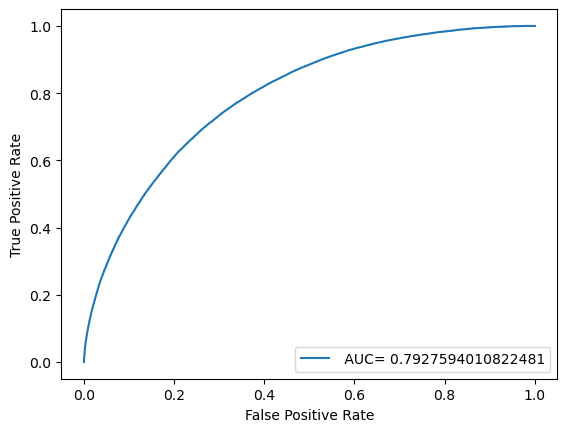

In [54]:
from sklearn import metrics
from matplotlib import pyplot as plt


#define metrics
y_pred_proba = final_model. predict_proba (X)[::,1]
fpr, tpr, _ = metrics. roc_curve (y, y_pred_proba)
auc = metrics. roc_auc_score (y, y_pred_proba)

#create ROC curve
plt.plot (fpr,tpr,label=" AUC= "+str(auc))
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc=4)
plt.show() 

# Финальная модель 

In [71]:
X_new=df_session.drop(['target'], axis=1)
y_new=df_session['target']
x_train_new, x_test_new, y_train_new, y_test_new = train_test_split(X_new, y_new, test_size=0.3, random_state=40)

In [72]:
lightgbm_best = LGBMClassifier(random_state=42, learning_rate=0.11355452645263, boosting_type='gbdt', 
        n_estimators=577, reg_lambda=30.833857088371047, reg_alpha=4.631152487867318, num_leaves=85)
lightgbm_best.fit(x_train_new, y_train_new)
# сделать предикт на тренировочных параметрах и выполнить оценку точности
pred_train = lightgbm_best.predict(x_train_new)
roc_auc_score(y_train_new, pred_train)
# сделать предикт на тестовых параметрах и выполнить оценку точности
pred_test = lightgbm_best.predict(x_test_new)
roc_auc_score(y_test_new, pred_test)
print('точность тренировочной выборки =', roc_auc_score(y_train_new, pred_train))
print('точность тестовой выборки =', roc_auc_score(y_test_new, pred_test))


точность тренировочной выборки = 0.5019109844208663
точность тестовой выборки = 0.5006905101238843


# Анализ влияния feauture на результаты моделирования
В итоге всех преобразований получается 25 признака


In [73]:
# выведем features и отсортируем по убыванию, чтобы понять, какие фичи вносят больший результат
lightgbm_best.feature_importances_
f_imp_list = list(zip(X.columns, lightgbm_best.feature_importances_))
f_imp_list.sort(key = lambda x: x[1], reverse=True)
f_imp_list=pd.DataFrame({"features": X.columns, "feature_importances": lightgbm_best.feature_importances_})
f_imp_list['feature_importances'].describe()

count     88.00000
mean     550.77273
std     1599.77531
min        0.00000
25%        0.00000
50%       29.00000
75%      102.50000
max     8821.00000
Name: feature_importances, dtype: float64

In [74]:
# обрежем features, которые имеют вклад 0 в модель, осталось 112 features 
f_imp_list_cut = f_imp_list.loc[f_imp_list['feature_importances']>0, :]
f_imp_list_cut['feature_importances'].describe()

count     53.00000
mean     914.49057
std     1985.66387
min        3.00000
25%       36.00000
50%       70.00000
75%      202.00000
max     8821.00000
Name: feature_importances, dtype: float64

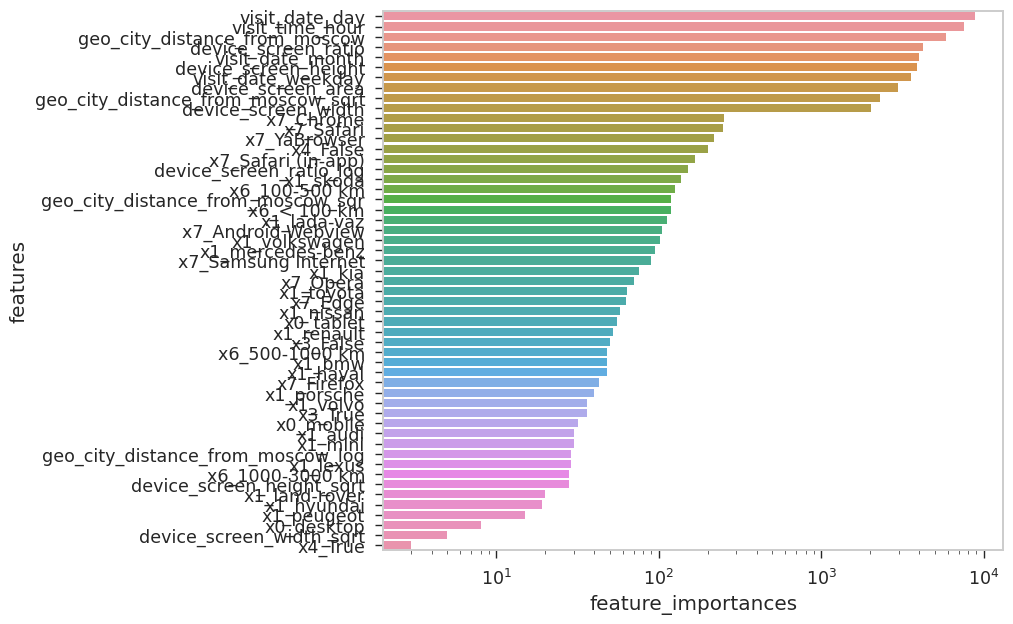

<Figure size 800x700 with 0 Axes>

In [75]:
## Выведем фичи, значения которых максимально вносят вклад в модель, логично, что это все revenue

from jupyterthemes import jtplot

jtplot.style(context='notebook', ticks=True, grid=False)
f_imp_list_cut = f_imp_list_cut.sort_values('feature_importances', ascending=False) 
sns.barplot(f_imp_list_cut['feature_importances'], f_imp_list_cut['features']).set(xscale="log")  
plt.figure()  
plt.show() 
sns.set (font_scale=0.04)

# Сохраним модель

In [76]:
import pickle
#cериализация модели 
filename = 'model.pickle'

with open(filename, 'wb') as file:
  pickle.dump(lightgbm_best, file) 


Выводы

Было проверено 10 моделей с гиперпараметрами по умолчанию. В тройке лучших оказались алгоритмы бустинга от sklearn, lightgbm и catboost.

В итоге в качестве лучшей модели был выбран LightGBM по следующим причинам:

Один из лучших показателей roc_auc.
Быстрое обучение.
Модель интерпретируема, то есть можно получить показатели важности признаков.
Может предсказывать вероятность класса.

Качество модели по метрике roc-auc составляет 0.73 (0.67 при предсказании классов). Переобучения нет и цель проекта выполнена - roc-auc > 0.65.

Для улучшения качества предсказания можно было бы:

Увеличить количество данных. Тестовая выборка пойдёт на дообучение модели, так что может модель будет лучше в конечном итоге.
Провести ребалансировку классов. Но если уменьшить выборку с отрицательной целевой переменной, то модель теряет в качестве, а если увеличивать выборку с положительным классом, то модели обучаются слишком долго.
Провести более тщательный поиск наилучших гиперпараметров - это займёт много времени, а прирост качества будет небольшим.
Провести дополнительную генерацию признаков. Но хорошие идеи придумывать сложно.
Попробовать более сложные модели, например, нейронные сети глубокого обучения.